# Generate plots for optimal combination workflow

In [34]:
%matplotlib inline
""""Bring in packages"""
# OS utilities
import os
from glob import glob
import shutil

# Math and plotting utilities
import numpy as np
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting

# URL data retrieval
import urllib.request

# Untarring utility
import tarfile

In [35]:
# Set up temporary directory
data_dir = '/tmp/optcom_plots'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Retrieve data
data_url = 'https://osf.io/e9q54/download'
data_remote_name = 'NIH_5_echo.tar.gz'
full_file = os.path.join(data_dir,data_remote_name)
with urllib.request.urlopen(data_url) as response, open(full_file, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
# Unzip data
with tarfile.open(full_file,'r:gz') as f_in:
    f_in.extractall(path=data_dir)
# Generate list of files to load
ted_dir = os.path.join(data_dir,'NIH_5_echo/')
files = ['p06.SBJ01_S09_Task11_e1.sm.nii.gz',
         'p06.SBJ01_S09_Task11_e2.sm.nii.gz',
         'p06.SBJ01_S09_Task11_e3.sm.nii.gz',
         'p06.SBJ01_S09_Task11_e4.sm.nii.gz',
         'p06.SBJ01_S09_Task11_e5.sm.nii.gz']
for i in range(len(files)):
    files[i] = os.path.join(ted_dir,files[i])
    
# Load files and create array of echoes
imgs = [nib.load(f) for f in files]
echo_times = np.array([15.4, 29.7, 44.0, 58.3, 72.6])

n_echoes = len(imgs)
n_trs = imgs[0].shape[-1]

pal = sns.color_palette('cubehelix', n_echoes)

In [36]:
# Select voxel from around middle of brain
ts = [img.get_data()[22, 40, 2, :] for img in imgs]

# Prepare data for model
ts_1d = np.hstack(ts) # data raveled out (T * E)
log_data = np.log(np.abs(ts_1d) + 1)
# log_data = np.log(ts_1d)  # in a perfect world...
x = np.column_stack([np.ones(n_echoes), -1 * echo_times])
X = np.repeat(x, n_trs, axis=0)  # T * E

# Model fit
betas = np.linalg.lstsq(X, log_data, rcond=None)[0]
s0 = np.exp(betas[0])
r2s = betas[1]
t2s = 1. / r2s

# Values for plots
# Values from log-linear model
log_x = np.arange(-80, 0, .01)
log_y = betas[0] + log_x*betas[1]

# Values from monoexponential decay model
mono_x = np.arange(0, 80, .01)
mono_y = np.exp(-1*betas[1]*mono_x) * s0

# Get weights for optimal combination
alpha = echo_times * np.exp(-echo_times / t2s)
alpha = alpha / np.sum(alpha)  # unnecessary but good for bar plot below

# Combine data across echoes
oc = np.average(np.vstack(ts), axis=0, weights=alpha)

## Echo-specific timeseries

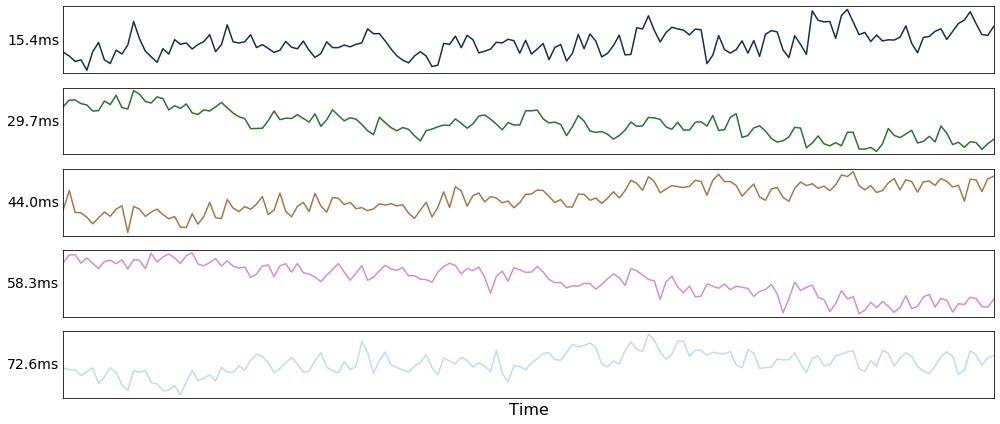

In [37]:
fig, axes = plt.subplots(n_echoes, sharex=True, sharey=False, figsize=(14, 6))
for i_echo in range(n_echoes):
    axes[i_echo].plot(ts[i_echo], color=pal[i_echo])
    axes[i_echo].set_ylabel('{0}ms'.format(echo_times[i_echo]), rotation=0, va='center', ha='right', fontsize=14)
    axes[i_echo].set_yticks([])
    axes[i_echo].set_xticks([])

axes[-1].set_xlabel('Time', fontsize=16)
axes[-1].set_xlim(0, len(ts[i_echo])-1)
fig.tight_layout()
fig.savefig('01_echo_timeseries.png', dpi=400)

## Echo-specific data and echo time

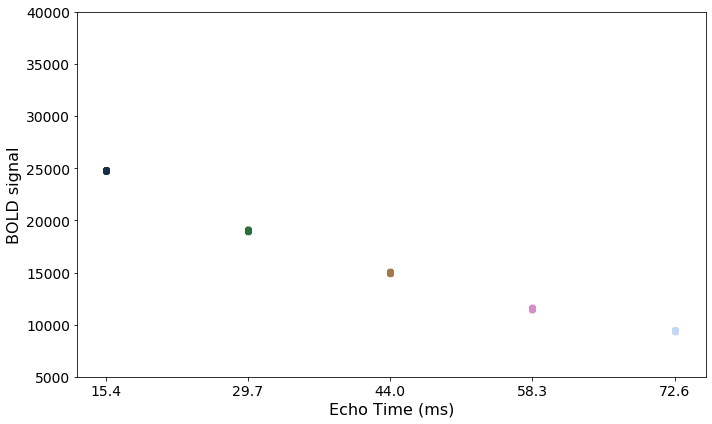

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
values = [i[0] for i in ts]
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(echo_times)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_ylim(5000, 40000)
fig.tight_layout()
fig.savefig('02_echo_value_distributions.png', dpi=400)

## Adaptive mask
Longer echo times are more susceptible to signal dropout, which means that certain brain regions (e.g., orbitofrontal cortex, temporal poles) will only have good signal for some echoes. In order to avoid using bad signal from affected echoes in calculating $T_{2}^*$ and $S_{0}$ for a given voxel, `tedana` generates an adaptive mask, where the value for each voxel is the number of echoes with "good" signal. When $T_{2}^*$ and $S_{0}$ are calculated below, each voxel's values are only calculated from the first $n$ echoes, where $n$ is the value for that voxel in the adaptive mask.

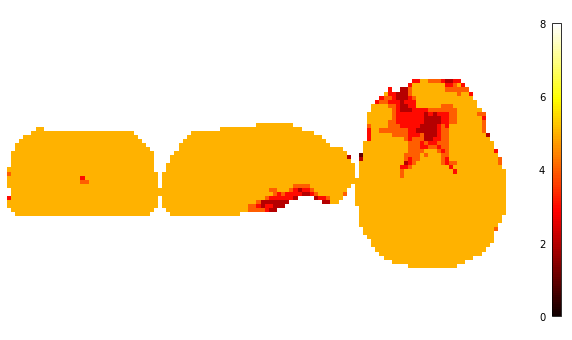

In [39]:
adaptive_mask_img = nib.load(op.join(ted_dir, 'adaptive_mask.nii'))
fig, ax = plt.subplots(figsize=(10, 6))

plotting.plot_stat_map(adaptive_mask_img, vmax=8, alpha=1,
                       cut_coords=[0, -4, 6],
                       draw_cross=False, colorbar=True,
                       annotate=False, bg_img=None, figure=fig, axes=ax)
fig.savefig('03_adaptive_mask.png', dpi=400)

## Log-linear transformation

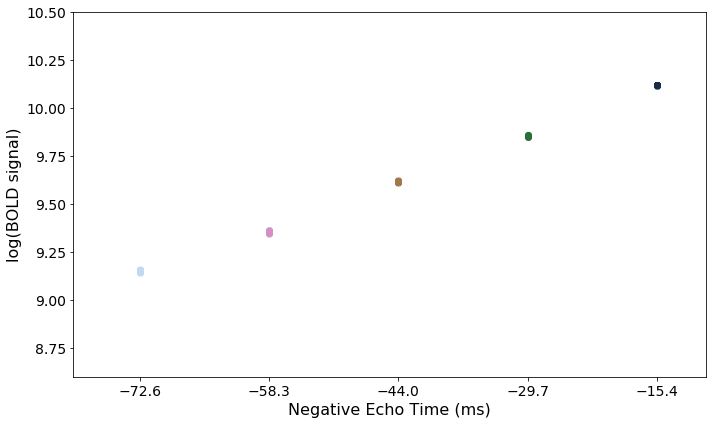

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
for i_echo in range(n_echoes):
    rep_echo_times = -1 * np.ones(n_trs) * echo_times[i_echo]
    log_echo_data = np.log((np.abs(ts[i_echo]) + 1))
    ax.scatter(rep_echo_times, log_echo_data, alpha=0.05, color=pal[i_echo])

ax.set_ylabel('log(BOLD signal)', fontsize=16)
ax.set_xlabel('Negative Echo Time (ms)', fontsize=16)
ax.set_xticks(-1 * echo_times)
ax.set_xlim(-80, -10)
ax.set_ylim(8.6, 10.5)
ax.tick_params(axis='both', which='major', labelsize=14)

fig.tight_layout()
fig.savefig('04_echo_log_value_distributions.png', dpi=400)

## Log-linear model

Let $S$ be the BOLD signal for a given echo.

Let $TE$ be the echo time in milliseconds.

$$\log_{e}(\left|\begin{pmatrix}
S(TE_{1}) \\
S(TE_{2}) \\
\vdots \\
S(TE_{n})\end{pmatrix}\right|
+
\begin{pmatrix}
1 \\
1 \\
\vdots \\
1\end{pmatrix}
) = B_{1}
\begin{pmatrix}
-TE_{1} \\
-TE_{2} \\
\vdots \\
-TE_{n}\end{pmatrix} + 
\begin{pmatrix}
B_{0} \\
B_{0} \\
\vdots \\
B_{0}\end{pmatrix}$$

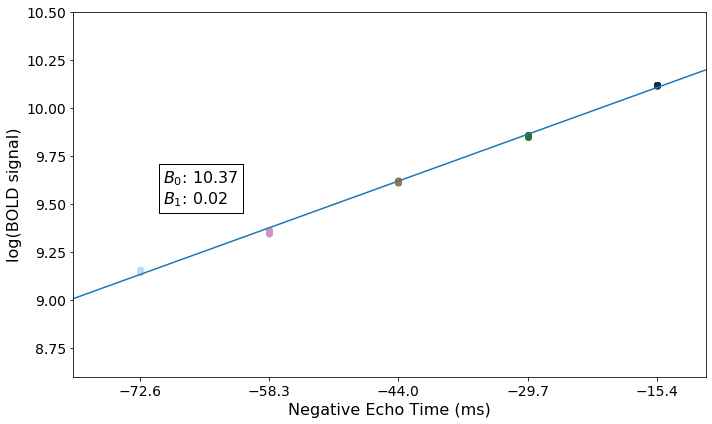

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
for i_echo in range(n_echoes):
    rep_echo_times = -1 * np.ones(n_trs) * echo_times[i_echo]
    log_echo_data = np.log((np.abs(ts[i_echo]) + 1))
    ax.scatter(rep_echo_times, log_echo_data, alpha=0.05, color=pal[i_echo])

ax.plot(log_x, log_y)

ax.set_ylabel('log(BOLD signal)', fontsize=16)
ax.set_xlabel('Negative Echo Time (ms)', fontsize=16)
ax.set_xticks(-1 * echo_times)
ax.set_xlim(-80, -10)
ax.set_ylim(8.6, 10.5)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.annotate('$B_0$: {0:.02f}\n$B_1$: {1:.02f}'.format(betas[0], betas[1]),
            xy=(-70, 9.5), fontsize=16,
            bbox=dict(fc="white", ec="black", lw=1))

fig.tight_layout()
fig.savefig('05_loglinear_regression.png', dpi=400)

# Monoexponential decay model
Calculation of $S_{0}$ and $T_{2}^{*}$
$$S_{0} = e^{B_{0}}$$

$$T_{2}^{*} = \frac{1}{B_{1}}$$

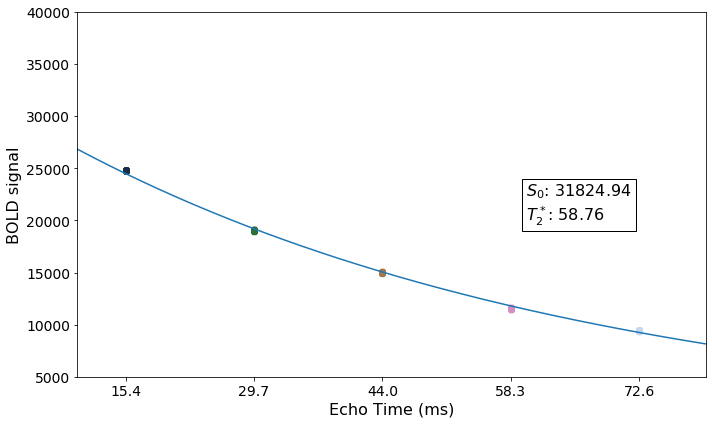

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(echo_times)
ax.set_xlim(10, 80)
ax.set_ylim(5000, 40000)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.annotate('$S_0$: {0:.02f}\n$T_2^*$: {1:.02f}'.format(s0, t2s),
            xy=(60, 20000), fontsize=16,
            bbox=dict(fc="white", ec="black", lw=1))

fig.tight_layout()
fig.savefig('06_monoexponential_decay_model.png', dpi=400)

## T2*

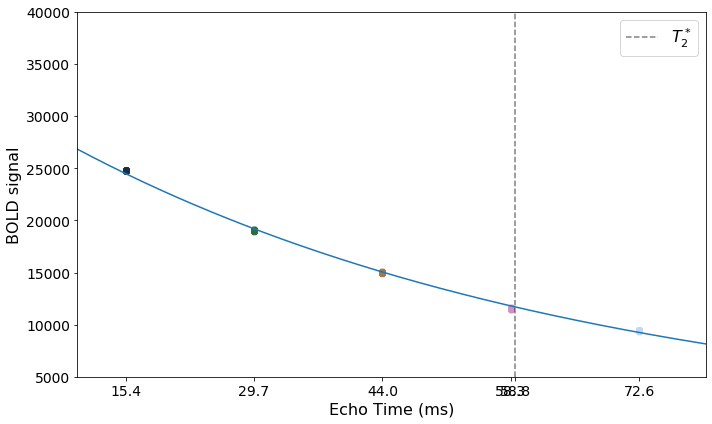

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

ax.axvline(t2s, 0, 1, label='$T_2^*$', color='black', linestyle='--', alpha=0.5)
ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(np.hstack((echo_times, [np.round(t2s, 1)])))
ax.set_xlim(10, 80)
ax.set_ylim(5000, 40000)
ax.tick_params(axis='both', which='major', labelsize=14)

legend = ax.legend(frameon=True, fontsize=16)

fig.tight_layout()
fig.savefig('07_monoexponential_decay_model_with_t2.png', dpi=400)

## Optimal combination weights

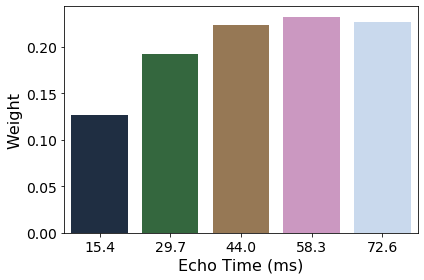

In [44]:
fig, ax = plt.subplots()
sns.barplot(echo_times, alpha, ax=ax, palette=pal)
ax.set_ylabel('Weight', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()
fig.savefig('08_optimal_combination_echo_weights.png', dpi=400)

## Optimally combined timeseries

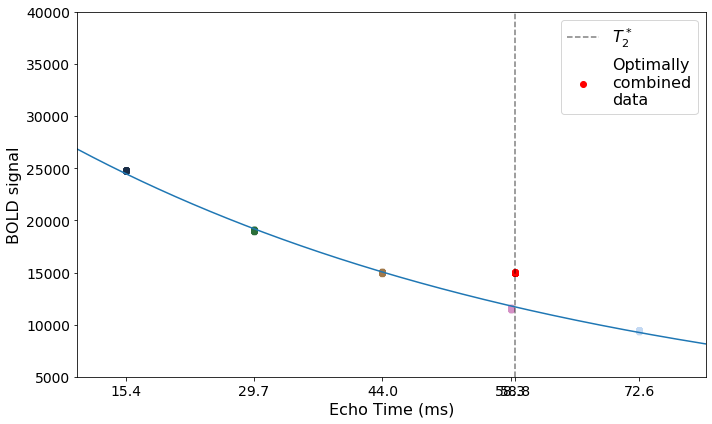

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

# Optimal combination
rep_t2s = np.ones(n_trs) * t2s
ax.scatter(rep_t2s, oc, alpha=1, color='red', label='Optimally\ncombined\ndata')

ax.axvline(t2s, 0, 20000, label='$T_2^*$', color='black', linestyle='--', alpha=0.5)
ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(np.hstack((echo_times, [np.round(t2s, 1)])))
ax.set_xlim(10, 80)
ax.set_ylim(5000, 40000)
ax.tick_params(axis='both', which='major', labelsize=14)

legend = ax.legend(frameon=True, fontsize=16)

fig.tight_layout()
fig.savefig('09_optimal_combination_value_distributions.png', dpi=400)

## Optimally combined timeseries

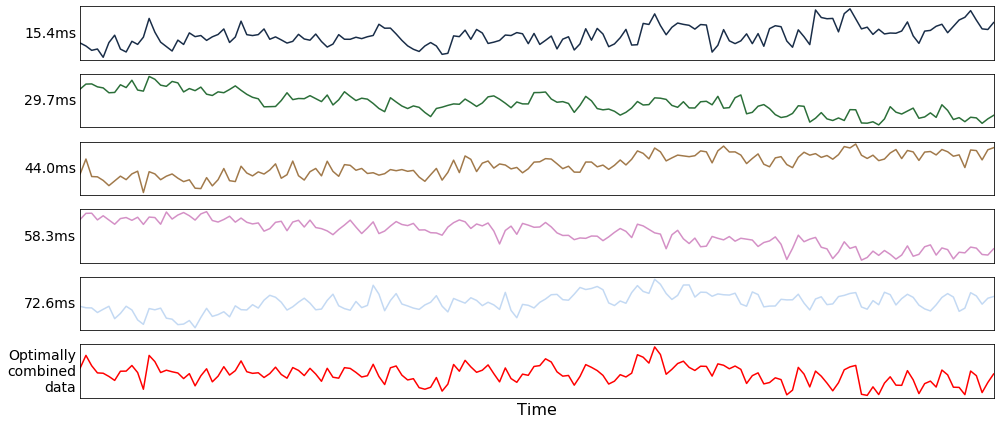

In [46]:
fig, axes = plt.subplots(n_echoes+1, sharex=True, sharey=False, figsize=(14, 6))
for i_echo in range(n_echoes):
    axes[i_echo].plot(ts[i_echo], color=pal[i_echo])
    axes[i_echo].set_ylabel('{0}ms'.format(echo_times[i_echo]), rotation=0, va='center', ha='right', fontsize=14)
    axes[i_echo].set_yticks([])
    axes[i_echo].set_xticks([])

axes[-1].plot(oc, color='red')
axes[-1].set_ylabel('Optimally\ncombined\ndata', rotation=0, va='center', ha='right', fontsize=14)
axes[-1].set_xlabel('Time', fontsize=16)
axes[-1].set_yticks([])
axes[-1].set_xticks([])
axes[-1].set_xlim(0, len(ts[i_echo])-1)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()
fig.savefig('10_optimal_combination_timeseries.png', dpi=400)